<a href="https://colab.research.google.com/github/Carterbouley/ElectricityPricePrediction/blob/master/multivariate_LSTM_electricity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [88]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"
from sklearn.preprocessing import StandardScaler, MinMaxScaler

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.test.is_gpu_available():
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Keras
from keras import Sequential
from keras.layers import Dense, LSTM, SimpleRNN, TimeDistributed, Dropout, Conv1D, GRU
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.optimizers import Adagrad
from keras.optimizers import RMSprop
from keras.optimizers import Nadam

# Common imports
import pandas as pd
import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt

#Parameters
window_hours = 168 #24*7
forecast_hours = 24
traing_hours = 24*365*4
test_hours = 24*365

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Function for plot
def plot_learning_curves(loss, val_loss, x_min_max=None, y_min_max=None):
    if x_min_max is None and y_min_max is None:
        x_min_max = [1,100]
        y_min_max = [0,70]
        
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([x_min_max[0], x_min_max[1], y_min_max[0], y_min_max[1]])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

No GPU was detected. LSTMs and CNNs can be very slow without a GPU.


In [89]:
#Read csv file
df = pd.read_csv('data_process_result/re_fixed_multivariate_timeseires.csv')
df.drop(df.loc[df['datetime'].duplicated()].index, inplace = True)
df['datetime'] = pd.to_datetime(df['datetime'])

df.set_index(df['datetime'], inplace = True)
df.drop(columns = [ 'datetime'], inplace = True)
df=df.dropna()

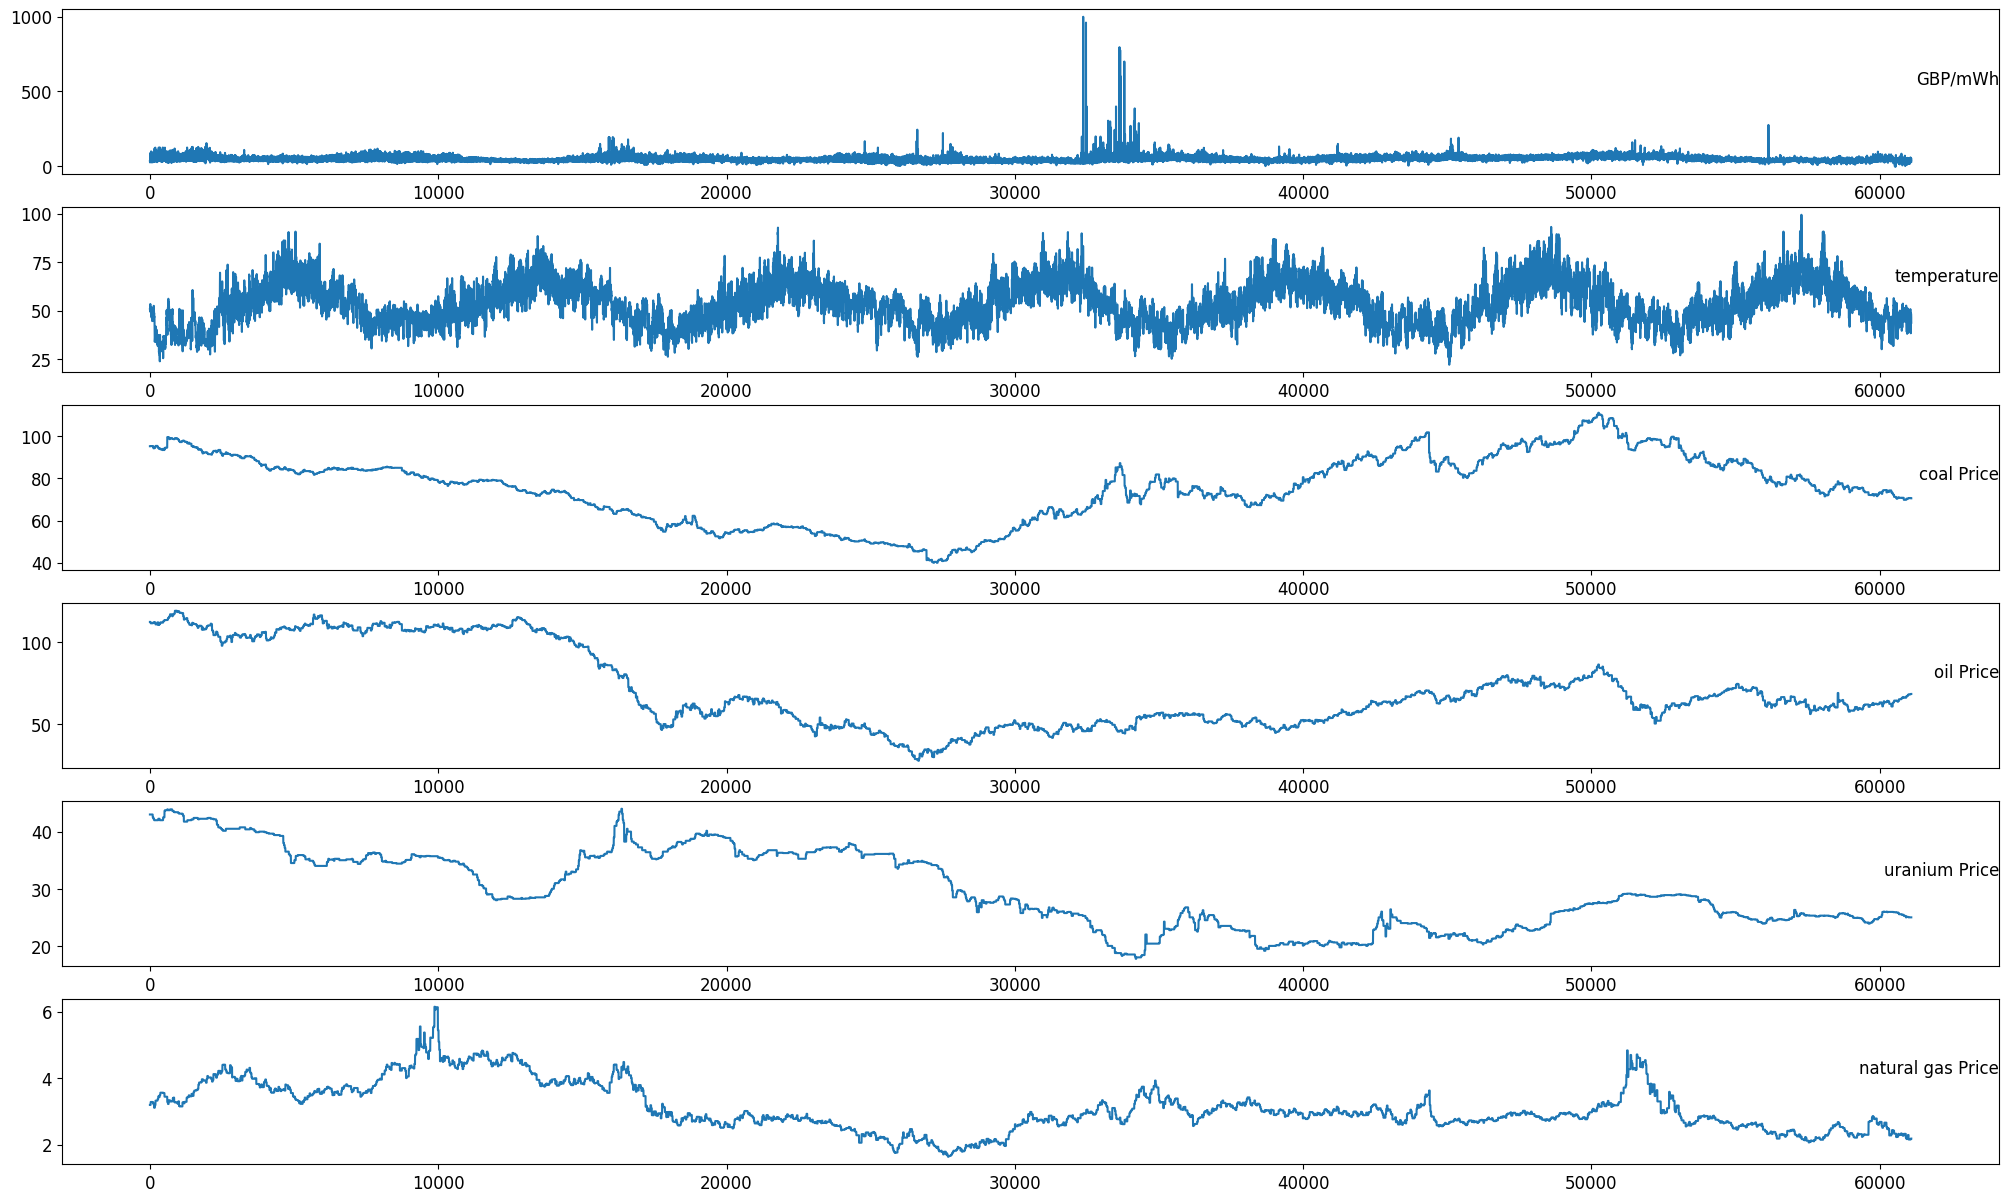

In [90]:
#Plot graph
values = df.values

groups = [0, 1, 2, 3, 4, 5]
i = 1

# plot each column
plt.figure(figsize = (25, 15))
for group in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(values[:, group])
	plt.title(df.columns[group], y=0.5, loc='right')
	i += 1
plt.show()

In [91]:
# Normalize Datafram
scaler = MinMaxScaler()

scaled_df = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled_df)

data = scaled_df.values

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

168+24 인 192 시간으로 데이터를 편집한 것은 168시간으로 학습 시킨 뒤 24 시간을 예측하게 만들기 위함이라 예상됨

In [92]:
# 192hours time window (n_step+24)
series_reshaped =  np.array([data[i:i + (window_hours+forecast_hours)].copy() for i in range(len(data) - (window_hours+forecast_hours))])
print(series_reshaped.shape)

(60905, 192, 6)


In [93]:
# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# Train, valid, test data 만들기
X_train = series_reshaped[:traing_hours, :window_hours]
X_valid = series_reshaped[traing_hours:series_reshaped.shape[0]-test_hours, :window_hours]
X_test = series_reshaped[series_reshaped.shape[0]-test_hours:, :window_hours]
Y = np.empty((series_reshaped.shape[0], window_hours, forecast_hours))

for step_ahead in range(1, forecast_hours + 1):
    Y[..., step_ahead - 1] = series_reshaped[..., step_ahead:step_ahead + window_hours, 0]
Y_train = Y[:traing_hours]
Y_valid = Y[traing_hours:series_reshaped.shape[0]-test_hours]
Y_test = Y[series_reshaped.shape[0]-test_hours:]
print(X_train.shape, X_valid.shape, X_test.shape, Y_train.shape, Y_valid.shape, Y_test.shape)

(35040, 168, 6) (17105, 168, 6) (8760, 168, 6) (35040, 168, 24) (17105, 168, 24) (8760, 168, 24)


#Note#
X_train.shape = (8760, 168,6) -> Ex) (8760) 중 어느 1시간에 대해 (168) 1주에 대한 미래 결과치를 (6) 6개의 요소에 대해 나타낸 것
Y_train.shape = (8760, 168,24) -> Ex) (8760) 중 어느 1시간에 대해 (168) 1주에 대한 미래 전력가격 결과를 (24) 24시간에 대해 나타낸 것

Deep Multivariate Recurrant Neural Network

In [75]:
#Training 

model6 = Sequential([
    SimpleRNN(50, return_sequences=True, input_shape=[None, X_train.shape[2]]),
    SimpleRNN(50, return_sequences=True),
    TimeDistributed(keras.layers.Dense(forecast_hours))
])
LR = 0.001
n_epochs = 150 #500

#es = EarlyStopping(monitor = 'val_loss',mode = 'min', verbose = 1, patience = 50)  # Early Stopping
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True) # Model Choice


model6.compile(loss="mape", optimizer=RMSprop(lr=0.001, rho=0.9, momentum=0.0, epsilon=1e-07, centered=False))
history = model6.fit(X_train, Y_train, epochs=n_epochs,
                    validation_data=(X_valid, Y_valid), callbacks=[mc])
#history = model6.fit(X_train, Y_train, epochs=n_epochs,
#                    validation_data=(X_valid, Y_valid), callbacks=[es,mc])

Epoch 1/150
548/548 [==============================] - 31s 55ms/step - loss: 109.4726 - val_loss: 122.4405
Epoch 2/150
548/548 [==============================] - 30s 54ms/step - loss: 49.8415 - val_loss: 83.4500
Epoch 3/150
548/548 [==============================] - 30s 54ms/step - loss: 29.6168 - val_loss: 34.6129
Epoch 4/150
548/548 [==============================] - 29s 54ms/step - loss: 15.1192 - val_loss: 22.5568
Epoch 5/150
548/548 [==============================] - 29s 54ms/step - loss: 12.9324 - val_loss: 21.4565
Epoch 6/150
548/548 [==============================] - 29s 54ms/step - loss: 12.1624 - val_loss: 20.9919
Epoch 7/150
548/548 [==============================] - 29s 54ms/step - loss: 11.7354 - val_loss: 18.2730
Epoch 8/150
548/548 [==============================] - 29s 54ms/step - loss: 11.4271 - val_loss: 16.6382
Epoch 9/150
548/548 [==============================] - 30s 54ms/step - loss: 11.2112 - val_loss: 16.6830
Epoch 10/150
548/548 [==============================]

KeyboardInterrupt: 

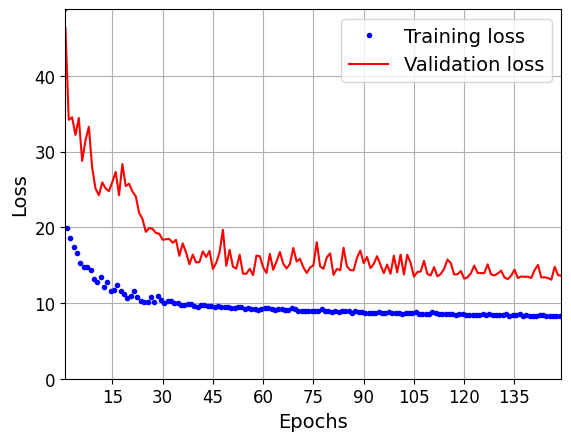

In [49]:
plot_learning_curves(history.history["loss"], history.history["val_loss"],[1,max(history.epoch)],[0, max(max(history.history["loss"]),max(history.history["val_loss"]))])
plt.show()

75/75 [==============================] - 1s 11ms/step


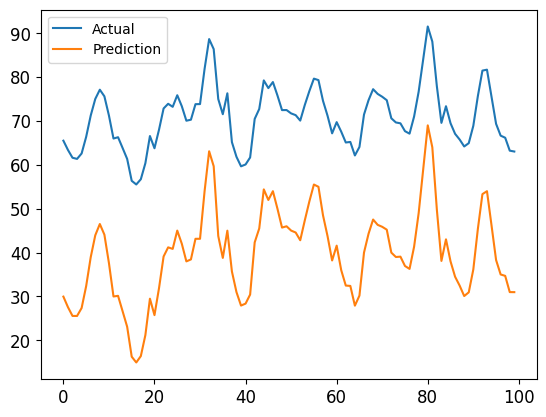

In [32]:
#Predict

Y_pred = model6.predict(X_test)

last_list=[]

for i in range (0, len(Y_pred)):
  last_list.append((Y_pred[i,0,Y_pred.shape[2]-1]))  # 왜 마지막을 예측값으로 사용하는가..... .?!
    

actual = pd.DataFrame((X_test[:,0]))
actual.rename(columns = {0:'nor_actual'}, inplace = True)
actual['nor_predictions'] = last_list
actual['difference'] = (actual['nor_predictions'] - actual['nor_actual']).abs()
actual['difference_percentage'] = ((actual['difference'])/(actual['nor_actual']))*100

#Inverse_transform
Y_pred_inverse = (actual['nor_predictions'] * (df['GBP/mWh'].max() - df['GBP/mWh'].min()) + df['GBP/mWh'].min())
Y_act_inverse = (actual['nor_actual'] * (df['GBP/mWh'].max() - df['GBP/mWh'].min()) + df['GBP/mWh'].min())
actual['Actual'] = Y_pred_inverse
actual['Prediction'] = Y_act_inverse

actual.to_csv('model_result/SimpleRNNresults.csv') 

actual['Actual'][:100].plot(legend=True)
actual['Prediction'][:100].plot(legend=True)

actual1 = actual

Simple Long-Short Term Memory Model

In [95]:
# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

model8 = Sequential([
    LSTM(20, return_sequences=True, input_shape=[None, X_train.shape[2]]),
    TimeDistributed(Dense(forecast_hours))
])

n_epochs = 150
#es = EarlyStopping(monitor = 'val_loss',mode = 'min', verbose = 1, patience = 50)  # Early Stopping
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True) # Model Choice

model8.compile(loss="mape", optimizer=Nadam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07))
history = model8.fit(X_train, Y_train, epochs=n_epochs,
                    validation_data=(X_valid, Y_valid), callbacks=[mc])
#history = model8.fit(X_train, Y_train, epochs=n_epochs,
#                    validation_data=(X_valid, Y_valid), callbacks=[es,mc])


Epoch 1/150
1095/1095 [==============================] - 33s 28ms/step - loss: 25.2512 - val_loss: 18.9151
Epoch 2/150
1095/1095 [==============================] - 32s 29ms/step - loss: 16.5628 - val_loss: 18.1646
Epoch 3/150
1095/1095 [==============================] - 31s 29ms/step - loss: 15.6464 - val_loss: 17.0455
Epoch 4/150
1095/1095 [==============================] - 31s 28ms/step - loss: 14.4860 - val_loss: 14.8281
Epoch 5/150
1095/1095 [==============================] - 32s 29ms/step - loss: 12.9746 - val_loss: 13.9560
Epoch 6/150
1095/1095 [==============================] - 31s 28ms/step - loss: 12.4628 - val_loss: 13.3471
Epoch 7/150
1095/1095 [==============================] - 31s 28ms/step - loss: 12.2040 - val_loss: 13.2441
Epoch 8/150
1095/1095 [==============================] - 31s 28ms/step - loss: 11.8152 - val_loss: 13.2276
Epoch 9/150
1095/1095 [==============================] - 31s 28ms/step - loss: 11.4794 - val_loss: 12.8567
Epoch 10/150
1095/1095 [=============

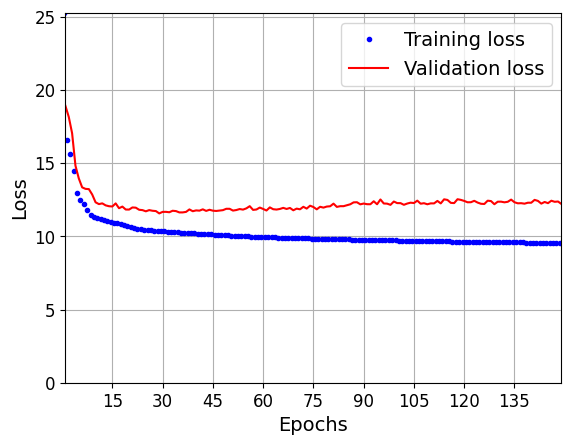

In [96]:
plot_learning_curves(history.history["loss"], history.history["val_loss"],[1,max(history.epoch)],[0, max(max(history.history["loss"]),max(history.history["val_loss"]))])
plt.show()

274/274 [==============================] - 3s 9ms/step


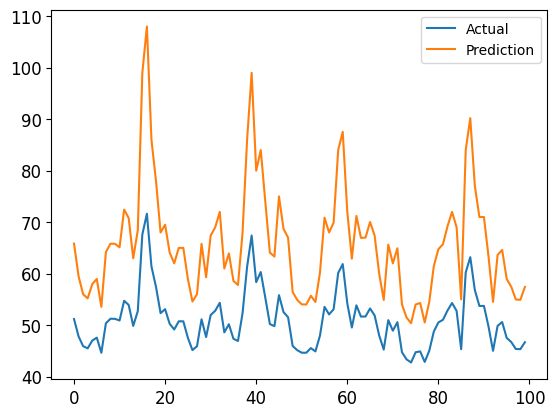

In [97]:
#Predict

Y_pred = model8.predict(X_test)

last_list=[]

for i in range (0, len(Y_pred)):
  last_list.append((Y_pred[i,0,Y_pred.shape[2]-1]))  # 왜 마지막을 예측값으로 사용하는가..... .?!
    
actual = pd.DataFrame((X_test[:,0]))
actual.rename(columns = {0:'nor_actual'}, inplace = True)
actual['nor_predictions'] = last_list
actual['difference'] = (actual['nor_predictions'] - actual['nor_actual']).abs()
actual['difference_percentage'] = ((actual['difference'])/(actual['nor_actual']))*100

#Inverse_transform
Y_pred_inverse = (actual['nor_predictions'] * (df['GBP/mWh'].max() - df['GBP/mWh'].min()) + df['GBP/mWh'].min())
Y_act_inverse = (actual['nor_actual'] * (df['GBP/mWh'].max() - df['GBP/mWh'].min()) + df['GBP/mWh'].min())
actual['Actual'] = Y_pred_inverse
actual['Prediction'] = Y_act_inverse

actual['Actual'][:100].plot(legend=True)
actual['Prediction'][:100].plot(legend=True)


actual.to_csv('model_result/LSTMresults.csv') 
actual2 = actual

Deep LSTM model

In [98]:
# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

model9 = Sequential([
    LSTM(80, return_sequences=True, input_shape=[None, X_train.shape[2]]),
    Dropout(0,2),
    LSTM(40, return_sequences=True),
    Dropout(0,2),
    LSTM(30, return_sequences=True),
    TimeDistributed(Dense(forecast_hours))
])

n_epochs = 150
model9.compile(loss="mape", optimizer="adam")
#es = EarlyStopping(monitor = 'val_loss',mode = 'min', verbose = 1, patience = 50)  # Early Stopping
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True) # Model Choice
history = model9.fit(X_train, Y_train, epochs=n_epochs,
                    validation_data=(X_valid, Y_valid), callbacks = [mc])
#history = model9.fit(X_train, Y_train, epochs=n_epochs,
#                    validation_data=(X_valid, Y_valid), callbacks = [es,mc])

Epoch 1/150
1095/1095 [==============================] - 137s 122ms/step - loss: 16.2348 - val_loss: 15.6605
Epoch 2/150
1095/1095 [==============================] - 132s 120ms/step - loss: 13.4833 - val_loss: 14.7880
Epoch 3/150
1095/1095 [==============================] - 131s 120ms/step - loss: 11.7218 - val_loss: 13.6401
Epoch 4/150
1095/1095 [==============================] - 131s 120ms/step - loss: 11.1916 - val_loss: 13.0922
Epoch 5/150
1095/1095 [==============================] - 132s 121ms/step - loss: 11.0223 - val_loss: 12.8786
Epoch 6/150
1095/1095 [==============================] - 132s 121ms/step - loss: 10.7174 - val_loss: 13.5341
Epoch 7/150
1095/1095 [==============================] - 132s 121ms/step - loss: 10.4578 - val_loss: 13.7383
Epoch 8/150
1095/1095 [==============================] - 132s 121ms/step - loss: 10.1941 - val_loss: 13.8227
Epoch 9/150
1095/1095 [==============================] - 132s 121ms/step - loss: 9.9199 - val_loss: 13.5648
Epoch 10/150
1095/10

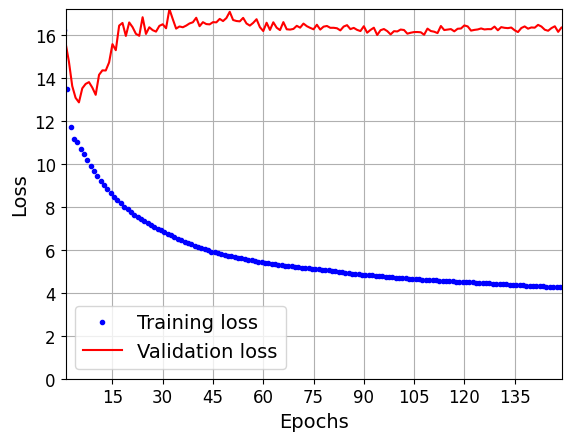

In [99]:
plot_learning_curves(history.history["loss"], history.history["val_loss"],[1,max(history.epoch)],[0, max(max(history.history["loss"]),max(history.history["val_loss"]))])
plt.show()

274/274 [==============================] - 12s 40ms/step


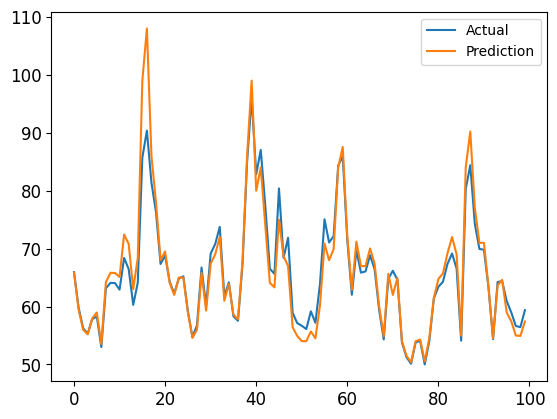

In [100]:
#Predict

Y_pred = model9.predict(X_test)

last_list=[]

for i in range (0, len(Y_pred)):
  last_list.append((Y_pred[i,0,Y_pred.shape[2]-1]))  # 왜 마지막을 예측값으로 사용하는가..... .?!
    

actual = pd.DataFrame((X_test[:,0]))
actual.rename(columns = {0:'nor_actual'}, inplace = True)
actual['nor_predictions'] = last_list
actual['difference'] = (actual['nor_predictions'] - actual['nor_actual']).abs()
actual['difference_percentage'] = ((actual['difference'])/(actual['nor_actual']))*100

#Inverse_transform
Y_pred_inverse = (actual['nor_predictions'] * (df['GBP/mWh'].max() - df['GBP/mWh'].min()) + df['GBP/mWh'].min())
Y_act_inverse = (actual['nor_actual'] * (df['GBP/mWh'].max() - df['GBP/mWh'].min()) + df['GBP/mWh'].min())
actual['Actual'] = Y_pred_inverse
actual['Prediction'] = Y_act_inverse

actual['Actual'][:100].plot(legend=True)
actual['Prediction'][:100].plot(legend=True)


actual.to_csv('model_result/DeepLSTMresults.csv') 
actual3 = actual

Conv1D?

In [ ]:
# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

model10 = Sequential([
    Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",
                        input_shape=[None, X_train.shape[2]]),
    GRU(60, return_sequences=True),
    GRU(40, return_sequences=True),
    TimeDistributed(Dense(forecast_hours))
])

n_epochs = 500
model10.compile(loss="mape", optimizer="adam")
#es = EarlyStopping(monitor = 'val_loss',mode = 'min', verbose = 1, patience = 50)  # Early Stopping
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True) # Model Choice
history2 = model10.fit(X_train, Y_train[:, 3::2], epochs=n_epochs,
                    validation_data=(X_valid, Y_valid[:, 3::2]), callbacks = [mc])
#history2 = model10.fit(X_train, Y_train[:, 3::2], epochs=n_epochs,
#                    validation_data=(X_valid, Y_valid[:, 3::2]), callbacks = [es,mc])

Epoch 1/500
548/548 [==============================] - 30s 50ms/step - loss: 20.1465 - val_loss: 20.2326
Epoch 2/500
548/548 [==============================] - 27s 49ms/step - loss: 13.9747 - val_loss: 16.8128
Epoch 3/500
548/548 [==============================] - 27s 49ms/step - loss: 12.6040 - val_loss: 16.8075
Epoch 4/500
548/548 [==============================] - 27s 49ms/step - loss: 11.6067 - val_loss: 15.8368
Epoch 5/500
548/548 [==============================] - 27s 49ms/step - loss: 11.1065 - val_loss: 14.8159
Epoch 6/500
548/548 [==============================] - 27s 49ms/step - loss: 10.6634 - val_loss: 14.5553
Epoch 7/500
548/548 [==============================] - 27s 49ms/step - loss: 10.2541 - val_loss: 14.4075
Epoch 8/500
548/548 [==============================] - 27s 49ms/step - loss: 10.0435 - val_loss: 13.9985
Epoch 9/500
548/548 [==============================] - 27s 49ms/step - loss: 9.8779 - val_loss: 14.4603
Epoch 10/500
548/548 [==============================] - 

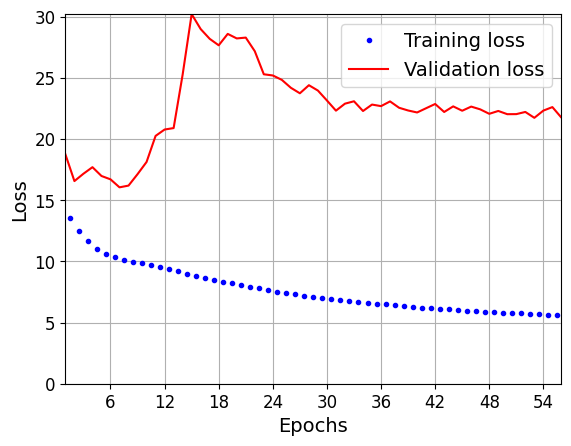

In [ ]:
plot_learning_curves(history.history["loss"], history.history["val_loss"],[1,max(history.epoch)],[0, max(max(history.history["loss"]),max(history.history["val_loss"]))])
plt.show()

274/274 [==============================] - 9s 32ms/step


<Axes: >

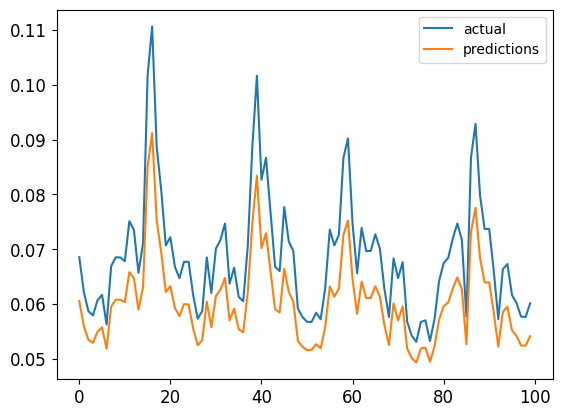

In [ ]:
#Predict

Y_pred = model9.predict(X_test)

last_list=[]

for i in range (0, len(Y_pred)):
  last_list.append((Y_pred[i,0,Y_pred.shape[2]-1]))  # 왜 마지막을 예측값으로 사용하는가..... .?!
    

actual = pd.DataFrame((X_test[:,0]))
actual.rename(columns = {0:'nor_actual'}, inplace = True)
actual['nor_predictions'] = last_list
actual['difference'] = (actual['nor_predictions'] - actual['nor_actual']).abs()
actual['difference_percentage'] = ((actual['difference'])/(actual['nor_actual']))*100

#Inverse_transform
Y_pred_inverse = (actual['nor_predictions'] * (df['GBP/mWh'].max() - df['GBP/mWh'].min()) + df['GBP/mWh'].min())
Y_act_inverse = (actual['nor_actual'] * (df['GBP/mWh'].max() - df['GBP/mWh'].min()) + df['GBP/mWh'].min())
actual['Actual'] = Y_pred_inverse
actual['Prediction'] = Y_act_inverse

actual['Actual'][:100].plot(legend=True)
actual['Prediction'][:100].plot(legend=True)


actual.to_csv('model_result/ConvIDresult.csv') 
actual4 = actual